In [8]:
#Import needed library
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# sklearn: scikit-learn
# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# models
## Scikit-Learn
# regularization: mitigate overfitting
from sklearn.linear_model import LinearRegression, Lasso, Ridge # Linear Regression with regularization
# random forest
from sklearn.ensemble import RandomForestRegressor
# decision tree
from sklearn.tree import DecisionTreeRegressor
# extreme gradient boosting
import xgboost as xgb

## Statsmodels
import statsmodels.api as sm # R-squared, p-value
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor # multicollinearity

# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression

# metrics
from sklearn.metrics import mean_squared_error, r2_score # R-squared ~ coefficient of determination

# seaborn for visualization
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# statistics
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# # plotting
import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 10}
matplotlib.rc('font', **font)

### PREDICT HOUSE PRICING WITH LINEAR REGRESSION

#### 1. Data loading & quick EDA

In [9]:
train = 'https://raw.githubusercontent.com/giangtran317/EDA/main/housing_price/train.csv'
df = pd.read_csv(train)
df.shape

(1460, 81)

In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

> *SalePrice is the target value to predict*

In [10]:
#Drop ID column because it is not necessary 
df = df.drop(columns =['Id'])

Have a look at SalePrice distribution


 mu = 180921.20 and sigma = 79415.29



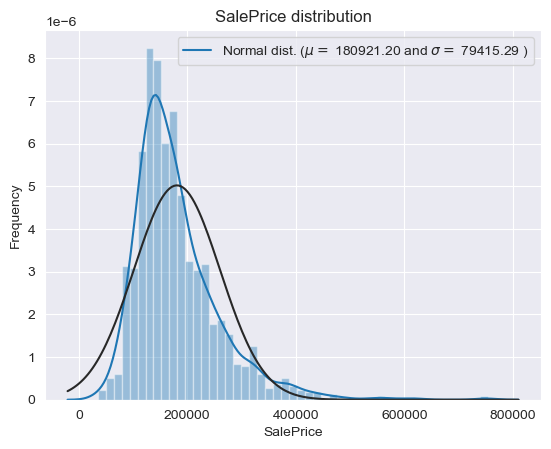

In [11]:
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.show()

#### 2. Data pre-processing

##### 2.1 Address null & nan value

In [12]:
df_na = (df.isnull().sum()/len(df))*100

In [13]:
#column without null values
non_null_columns = df_na[df_na == 0].index

#exclude all those column 
df_na = df_na.drop(non_null_columns)

#sort for better look 
df_na = df_na.sort_values(ascending = False) 

missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


Drop columns which has missrate >=10%

In [14]:
missing_drop_cols = list(missing_data[missing_data["miss_rate"] >= 10].index)

df_non_na = df.drop(columns = missing_drop_cols)

Fill null values: mean for numeric data and mode for categorical data 

In [15]:
#caculate mean to fill na
means = df_non_na._get_numeric_data().mean()
#fill na 
df_non_na._get_numeric_data().fillna(means, inplace=True)

In [16]:
#Categorical cols has missing value 
df_na = (df_non_na.isnull().sum() / len(df_non_na)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data

,miss_rate
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945
GarageCond,5.547945
BsmtExposure,2.602740
BsmtFinType2,2.602740
BsmtQual,2.534247
BsmtCond,2.534247
BsmtFinType1,2.534247
MasVnrType,0.547945


In [17]:
#calculate mode 
modes = df_non_na.mode()

#fill mode to null categorical cols 
df_non_na = df_non_na.fillna(modes.to_dict(orient='records')[0])

In [18]:
# Check missing values again
df_na = (df_non_na.isnull().sum() / len(df_non_na)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data

,miss_rate


##### 2.2 Remove highly collerated variables

Calculate Pearson correlation coefficients betweens the pairs of columns (except for SalePrice)

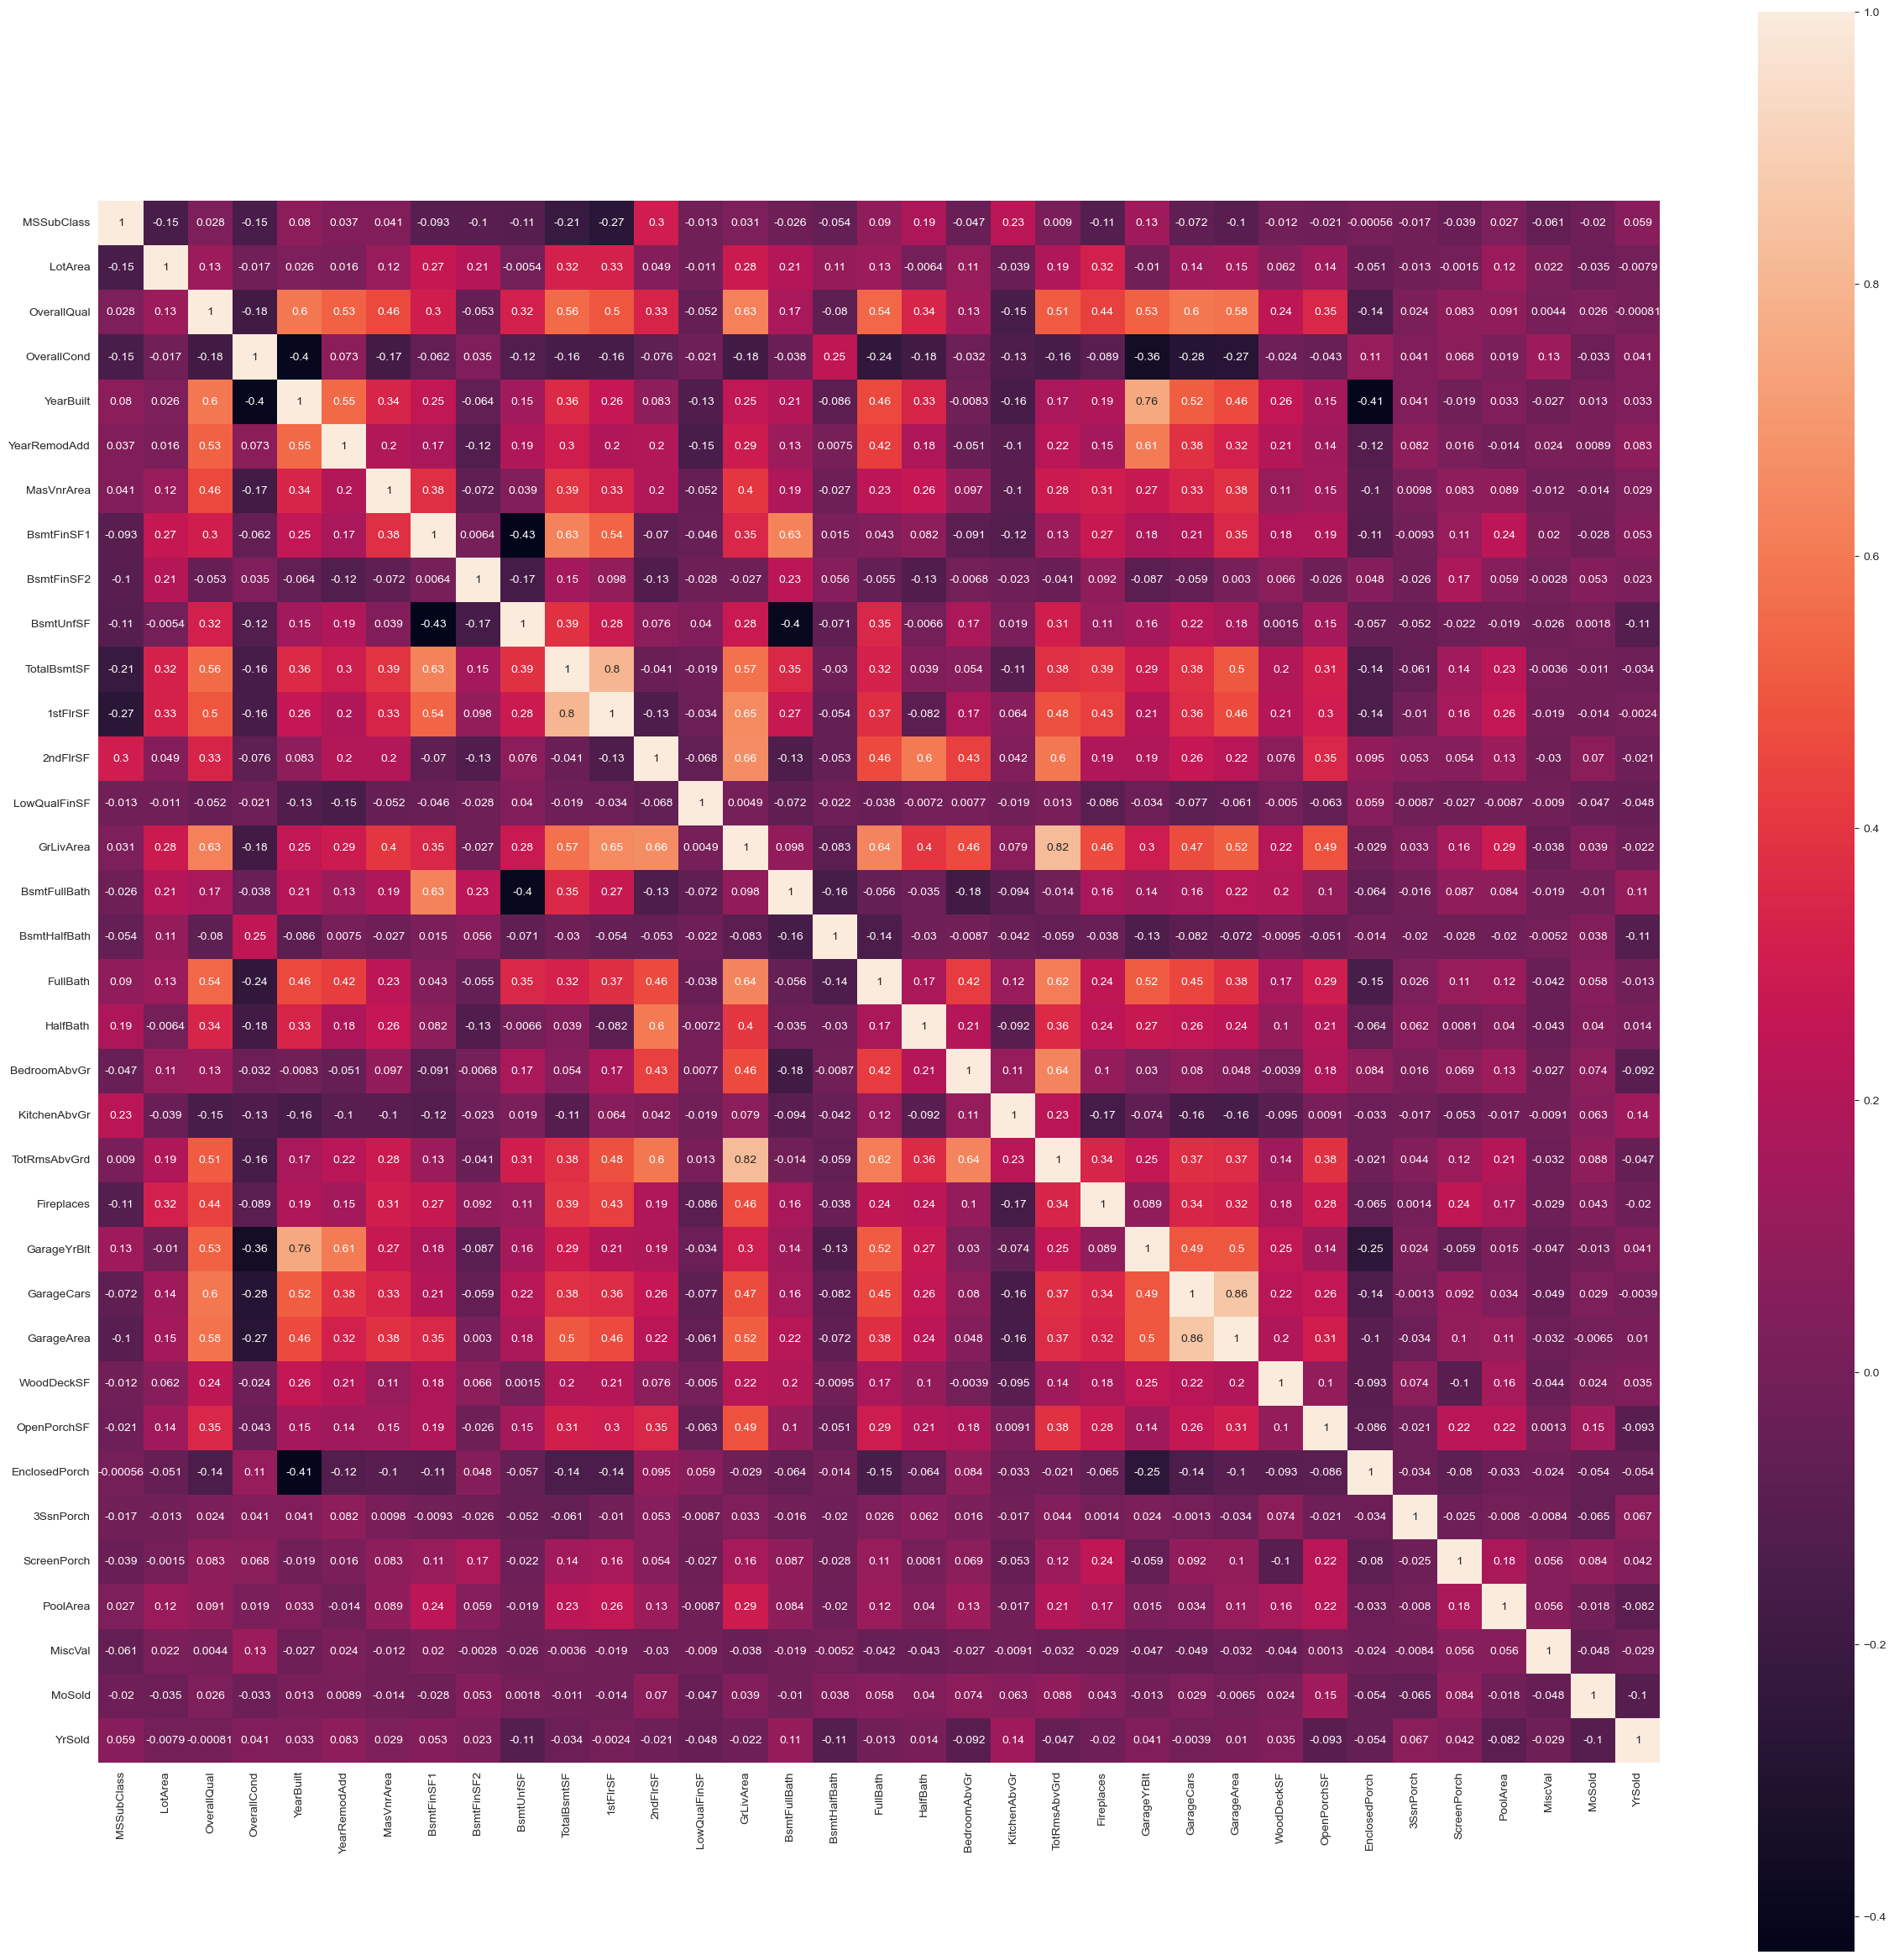

In [19]:
#filer only numeric feature without saleprice with 25% sample for better running time 
sample_numeric_features = df_non_na.drop(columns = 'SalePrice')._get_numeric_data().sample(frac = 0.25)

#calculate Correlation matrix 
corr_matrix = sample_numeric_features.corr()

#plot heatmap of corr_matrix 
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

In each pair of columns has high correlation (>0.8 or <-0.8), indentify one column to drop

In [20]:
# threshold above which is considered too high of a correlation
corr_threshold = 0.8

# Create correlation matrix
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than the correlation threshold
to_drop_corr = [column for column in upper.columns if any(upper[column] >= corr_threshold)]
print(to_drop_corr)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


Training data

In [21]:
train_df = df_non_na.drop(columns = to_drop_corr)
train_df.shape

(1460, 71)

##### 2.3 Feature scaling: to scale feature value have the same range 

Handle numeric data

In [22]:
# drop col SalePrice 
num_cols = train_df.drop(columns = 'SalePrice').select_dtypes(include='number').columns

In [23]:
scaler = MinMaxScaler()

#fit data to scaler function 
scaled_train_df = scaler.fit_transform(train_df[num_cols])

train_df[num_cols] = scaled_train_df

train_df[num_cols].describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.217043,0.043080,0.566591,0.571918,0.719332,0.581096,0.064803,0.078604,0.031580,0.242826,...,0.441781,0.109970,0.085302,0.039772,0.006712,0.031377,0.003738,0.002806,0.483811,0.453938
std,0.248827,0.046653,0.153666,0.139100,0.218862,0.344090,0.112856,0.080811,0.109443,0.189155,...,0.186829,0.146253,0.121126,0.110723,0.057711,0.116161,0.054441,0.032008,0.245784,0.332024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029229,0.444444,0.500000,0.594203,0.283333,0.000000,0.000000,0.000000,0.095462,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.250000
50%,0.176471,0.038227,0.555556,0.500000,0.731884,0.733333,0.000000,0.067948,0.000000,0.204409,...,0.500000,0.000000,0.045704,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000
75%,0.294118,0.048150,0.666667,0.625000,0.927536,0.900000,0.102656,0.126196,0.000000,0.345890,...,0.500000,0.196033,0.124314,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Handle categorical data

In [24]:
train_df.select_dtypes(include =  'object').head(5)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [25]:
train_df = pd.get_dummies(train_df, drop_first=True)
print(train_df.shape)

(1460, 229)


##### 2.4 Train-Test split: split train-test with the ratio 7:3

In [26]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop(columns='SalePrice'), train_df['SalePrice'], test_size=0.3, random_state=42)

In [27]:
print("x_train_shape: ", x_train.shape)
print("x_test_shape: ", x_test.shape)
print("y_train_shape: ", x_train.shape)
print("y_test_shape: ", x_test.shape)

x_train_shape:  (1022, 228)
x_test_shape:  (438, 228)
y_train_shape:  (1022, 228)
y_test_shape:  (438, 228)


#### 3. Linear Regression with scikit-learn

3.1 Initail train model

In [29]:
lr = LinearRegression()
#fit model 
lr.fit(x_train,y_train)

LinearRegression()

In [30]:
#predict on test set 
y_pred = lr.predict(x_test) 

Evaluate model with R-squared & Mean Squared Error

In [31]:
#evaluate on Test set 
# Root Mean Squared Error
print(f'RMSE       = {mean_squared_error(y_test, y_pred)**0.5:.2f}')

# R-squared: coefficient of determination
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')

RMSE       = 2794787715868184.00
R-squared = -1119336977168432365568.0000


>***model is not effecient***

Train model with only numeric features

In [33]:
x_train, x_test, y_train, y_test = train_test_split(train_df[num_cols], train_df.SalePrice, test_size=0.3, random_state=42)

lr = LinearRegression()
# Train the model using the training sets
# fit: learn the parameters based on the train set: Gradient Descent
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print(f'RMSE       = {mean_squared_error(y_test, y_pred)**0.5:.2f}')

# R-squared: coefficient of determination
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')

RMSE       = 35140.52
R-squared = 0.8230


3.2 Variance Inflation Factor: to check multicollinearity

Calculate Variance Inflation Factor of each column

In [35]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif["features"] = x_train.columns

Extract the columns having low multicollinearity

In [51]:
vif

,VIF Factor,features
0,2.684157,MSSubClass
1,2.072367,LotArea
2,46.657124,OverallQual
3,17.245519,OverallCond
4,51.747259,YearBuilt
5,8.476654,YearRemodAdd
6,1.906955,MasVnrArea
7,inf,BsmtFinSF1
8,inf,BsmtFinSF2
9,inf,BsmtUnfSF


In [52]:
col_use = list(vif[vif['VIF Factor'] < 15]['features'])

In [55]:
print('Number of column is:', len(col_use))

Number of column is: 20


In [82]:
x_train, x_test, y_train, y_test = train_test_split(train_df[col_use], train_df.SalePrice, test_size=0.3, random_state=42)

lr = LinearRegression()
# Train the model using the training sets
# fit: learn the parameters based on the train set: Gradient Descent
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print(f'RMSE       = {mean_squared_error(y_test, y_pred)**0.5:.2f}')

# R-squared: coefficient of determination
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')

RMSE       = 48333.93
R-squared = 0.6652


#### 4. Model interpretation with statsmodels

Train the model & interpret the result

In [83]:
est = sm.OLS(y_train,x_train) # OLS: ordinary least square
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              907.4
Date:                Mon, 24 Apr 2023   Prob (F-statistic):                        0.00
Time:                        15:24:54   Log-Likelihood:                         -12403.
No. Observations:                1022   AIC:                                  2.485e+04
Df Residuals:                    1002   BIC:                                  2.494e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Make predictions on the test set and evaluate the performance

In [84]:
y_test_prediction = est2.predict(x_test)

# Root Mean squared Error
print(f'RMSE       = {mean_squared_error(y_test, y_test_prediction)**0.5:.2f}')

# R-squared: coefficient of determination
print(f'R-squared = {r2_score(y_test, y_test_prediction):.4f}')

RMSE       = 49500.06
R-squared = 0.6489


Select the features with statistical significane based on p-values

In [74]:
high_pvalue = ['BsmtHalfBath','HalfBath','EnclosedPorch','3SsnPorch','MiscVal']
col_x_train = list(x_train.columns)

ft = [x for x in col_x_train if x not in high_pvalue]
ft

['MSSubClass',
 'LotArea',
 'YearRemodAdd',
 'MasVnrArea',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'YrSold']

Retrain the Model with the selected features

In [75]:
x_train, x_test, y_train, y_test = train_test_split(train_df[ft], train_df.SalePrice, test_size=0.3, random_state=42)

In [85]:
est = sm.OLS(y_train,x_train) # OLS: ordinary least square
est2 = est.fit()

In [86]:
y_test_prediction = est2.predict(x_test)

# Root Mean squared Error
print(f'RMSE       = {mean_squared_error(y_test, y_test_prediction)**0.5:.2f}')

# R-squared: coefficient of determination
print(f'R-squared = {r2_score(y_test, y_test_prediction):.4f}')

RMSE       = 49500.06
R-squared = 0.6489


#### 5. Feature selection

##### F-statistic as the criterion

Select k best features by SelectKBest with the F-statistic as the criterion

In [87]:
# Split Train-Test
x_train, x_test, y_train, y_test = train_test_split(train_df[num_cols], train_df.SalePrice, test_size=30, random_state=42)

# Number of selected features
num_selected = 10
# SelectKBest: select K best features
selector = SelectKBest(f_regression, k=num_selected)
selector.fit(x_train, y_train)

# Extract the k best features
x_train_selected = selector.transform(x_train)

In [89]:
# Create a new Linear Regression model
lr = LinearRegression()

# Train the linear regression model
lr.fit(x_train_selected, y_train)

# Extract the k best features in the test set 
x_test_selected = selector.transform(x_test)

# Make prediction on the test set
y_test_prediction = lr.predict(x_test_selected)

In [90]:
# Evaluation on Test set
# Root Mean squared Error
print(f'RMSE       = {mean_squared_error(y_test, y_test_prediction)**0.5:.2f}')

# R-squared: coefficient of determination
print(f'R-squared = {r2_score(y_test, y_test_prediction):.4f}')

RMSE       = 24047.56
R-squared = 0.8480


### **Choose model with R-square = 0.8480**